In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['opp_set_1', 'opp_set_2', 'opp_set_3']
sensor_names = ['s_m{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

In [3]:
train = pd.read_csv('/Users/rahulchauhan/Downloads/CMaps/train_FD001.txt',sep=' ', index_col=False, header=None, names=col_names)
test = pd.read_csv('/Users/rahulchauhan/Downloads/CMaps/test_FD001.txt',sep = ' ',index_col= False,header=None,names = col_names)
RUL = pd.read_csv('/Users/rahulchauhan/Downloads/CMaps/RUL_FD001.txt',sep = ' ',index_col= False,header=None,names = ['RUL'])

/var/folders/ls/cldmn3dj6mx5c8nw38zdl7yw0000gn/T/ipykernel_14004/3696279310.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  train = pd.read_csv('/Users/rahulchauhan/Downloads/CMaps/train_FD001.txt',sep=' ', index_col=False, header=None, names=col_names)
/var/folders/ls/cldmn3dj6mx5c8nw38zdl7yw0000gn/T/ipykernel_14004/3696279310.py:2: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  test = pd.read_csv('/Users/rahulchauhan/Downloads/CMaps/test_FD001.txt',sep = ' ',index_col= False,header=None,names = col_names)


In [4]:
train.head()

,unit_number,time_cycles,opp_set_1,opp_set_2,opp_set_3,s_m1,s_m2,s_m3,s_m4,s_m5,...,s_m12,s_m13,s_m14,s_m15,s_m16,s_m17,s_m18,s_m19,s_m20,s_m21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [5]:
print(train.shape)
print(test.shape)
print(RUL.shape)

(20631, 26)
(13096, 26)
(100, 1)


In [6]:
def add_rul(g):
    # Calculate the RUL as the difference between the maximum cycle value and the cycle value for each row
    g['RUL'] = max(g['time_cycles']) - g['time_cycles']
    return g

# Apply the add_rul function to the training data grouped by the unit ID
train_data = train.groupby('unit_number').apply(add_rul)

In [7]:
train_data.corrwith(train_data['RUL'])

/Users/rahulchauhan/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/rahulchauhan/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


unit_number    7.875253e-02
time_cycles   -7.362406e-01
opp_set_1     -3.198458e-03
opp_set_2     -1.947628e-03
opp_set_3               NaN
s_m1                    NaN
s_m2          -6.064840e-01
s_m3          -5.845204e-01
s_m4          -6.789482e-01
s_m5          -5.849749e-16
s_m6          -1.283484e-01
s_m7           6.572227e-01
s_m8          -5.639684e-01
s_m9          -3.901016e-01
s_m10                   NaN
s_m11         -6.962281e-01
s_m12          6.719831e-01
s_m13         -5.625688e-01
s_m14         -3.067689e-01
s_m15         -6.426670e-01
s_m16         -5.849749e-16
s_m17         -6.061536e-01
s_m18                   NaN
s_m19                   NaN
s_m20          6.294285e-01
s_m21          6.356620e-01
RUL            1.000000e+00
dtype: float64

In [8]:
def process_targets(data_length, early_rul = None):
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [9]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [10]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
  
    max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length= window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length= window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In [11]:
test_data = pd.read_csv('/Users/rahulchauhan/Downloads/CMaps/test_FD001.txt', sep = "\s+", header = None,names=col_names )
true_rul = pd.read_csv('/Users/rahulchauhan/Downloads/CMaps/RUL_FD001.txt', sep = '\s+', header = None)

window_length = 30
shift = 1
early_rul = 125           
processed_train_data = []
processed_train_targets = []
num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = ['unit_number','opp_set_1','opp_set_2','opp_set_3','s_m1','s_m5','s_m6','s_m7','s_m10','s_m16','s_m18','s_m19']

train_data_first_column = train ["unit_number"]
test_data_first_column = test_data["unit_number"]
num_train_windows = (len(train) - window_length) // shift + 1

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [13]:
train.head()

,unit_number,time_cycles,opp_set_1,opp_set_2,opp_set_3,s_m1,s_m2,s_m3,s_m4,s_m5,...,s_m12,s_m13,s_m14,s_m15,s_m16,s_m17,s_m18,s_m19,s_m20,s_m21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [14]:
scaler = StandardScaler()
train_data = scaler.fit_transform(train.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

In [15]:
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns=[0]).values
    
    # Determine whether it is possible to extract training data with the specified window length.
    if len(temp_train_data) < window_length:
        print(f"Train engine {i} doesn't have enough data for window_length of {window_length}")
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length=temp_train_data.shape[0], early_rul=early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length=window_length, shift=shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

# Concatenate processed data and targets into numpy arrays
processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

In [16]:
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values
    
    # Determine whether it is possible to extract test data with the specified window length.
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length=window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

In [17]:
print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed trianing data shape:  (17731, 30, 14)
Processed training ruls shape:  (17731,)
Processed test data shape:  (497, 30, 14)
True RUL shape:  (100,)


In [18]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (14184, 30, 14)
Processed validation data shape:  (3547, 30, 14)
Processed train targets shape:  (14184,)
Processed validation targets shape:  (3547,)


In [19]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Dropout,Conv1D,MaxPooling1D,LSTM,Flatten,BatchNormalization,Bidirectional
from tensorflow.keras.models import Sequential

/Users/rahulchauhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [20]:
import tensorflow as tf
from tensorflow.keras.optimizers import legacy

# Use legacy Adam optimizer
optimizer = legacy.Adam(learning_rate=0.001)


In [21]:
from sklearn.metrics import mean_squared_error

In [22]:
from keras.layers import TimeDistributed, Flatten

In [23]:
kernel_size = 3
model = Sequential()
intput_shape=(window_length, processed_train_data.shape[2])
model.add(Conv1D(128, kernel_size=kernel_size, padding = "same", activation="relu", input_shape = intput_shape))
model.add(Dropout(0))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Conv1D(128,kernel_size=kernel_size, padding = "same", activation="relu"))
model.add(Dropout(0))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(units = 128, return_sequences=True))
model.add(LSTM(units = 128, return_sequences=False))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'linear'))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')

In [24]:
def scheduler(epoch):
    if epoch < 5:
        return 0.001
    else:
        return 0.0001
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
#model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs = 10,
                    validation_data = (processed_val_data, processed_val_targets),
                    callbacks = callback,
                    batch_size = 64, verbose = 2)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
222/222 - 5s - loss: 2031.6490 - val_loss: 323.2769 - lr: 0.0010 - 5s/epoch - 25ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
222/222 - 4s - loss: 247.6604 - val_loss: 193.8854 - lr: 0.0010 - 4s/epoch - 18ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
222/222 - 4s - loss: 184.0537 - val_loss: 161.0054 - lr: 0.0010 - 4s/epoch - 17ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
222/222 - 4s - loss: 153.5699 - val_loss: 123.8733 - lr: 0.0010 - 4s/epoch - 16ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
222/222 - 3s - loss: 127.0340 - val_loss: 108.9916 - lr: 0.0010 - 3s/epoch - 16ms/step

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6/10
222/222 - 4s - loss: 91.6312 - val_loss: 76.1442 - lr: 1.0000e-04 - 4s/epoch - 16ms/step

Epoch 7: LearningRateSc

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 128)           5504      
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 15, 128)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 128)           49280     
                                                                 
 dropout_1 (Dropout)         (None, 15, 128)           0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 8, 128)            0         
 g1D)                                                   

In [26]:
rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

16/16 [==============================] - 0s 3ms/step
RMSE:  14.488865032397364


In [27]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)


RMSE (Taking only last examples):  15.288546948503276


In [28]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

S-score:  343.9804326854027


In [29]:
def create_compiled_model(lr=0.001, drop_CNN=0, drop_dense=0.2, kernel_size=3):
    model = Sequential()
    intput_shape=(window_length, processed_train_data.shape[2])
    model.add(Conv1D(128, kernel_size=kernel_size, padding = "same", activation="relu", input_shape = intput_shape))
    model.add(Dropout(drop_CNN))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(Conv1D(128,kernel_size=kernel_size, padding = "same", activation="relu"))
    model.add(Dropout(drop_CNN))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(units = 128, return_sequences=True))
    model.add(LSTM(units = 128, return_sequences=False))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(drop_CNN))
    model.add(Dense(1, activation = 'linear'))
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='mse')

    return model

In [30]:
def scheduler(epoch):
    if epoch < 5:
        return 0.001
    else:
        return 0.0001
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs = 10,
                    validation_data = (processed_val_data, processed_val_targets),
                    callbacks = callback,
                    batch_size = 64, verbose = 2)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
222/222 - 5s - loss: 2317.7764 - val_loss: 1779.7469 - lr: 0.0010 - 5s/epoch - 23ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
222/222 - 4s - loss: 732.1054 - val_loss: 264.7200 - lr: 0.0010 - 4s/epoch - 17ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
222/222 - 4s - loss: 179.8972 - val_loss: 163.8669 - lr: 0.0010 - 4s/epoch - 16ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
222/222 - 4s - loss: 136.0746 - val_loss: 156.7845 - lr: 0.0010 - 4s/epoch - 17ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
222/222 - 4s - loss: 103.8050 - val_loss: 95.2464 - lr: 0.0010 - 4s/epoch - 17ms/step

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6/10
222/222 - 4s - loss: 66.5498 - val_loss: 76.7227 - lr: 1.0000e-04 - 4s/epoch - 18ms/step

Epoch 7: LearningRateSc

In [31]:
rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

16/16 [==============================] - 0s 4ms/step
RMSE:  14.637747972796554


In [32]:
loss = history.history['loss']
val_loss = history.history['val_loss']

# Converting MSE to RMSE
loss_rmse = [round(val ** 0.5,2) for val in loss]
val_loss_rmse = [round(val ** 0.5,2) for val in val_loss]

# Creating a DataFrame
loss_df = pd.DataFrame({'loss_RMSE': loss_rmse, 'val_loss_RMSE': val_loss_rmse})
output = '/Users/rahulchauhan/Documents/IIT_G/MTP/LSTM + CNN Series/FD001.csv'
loss_df.to_csv(output,index = False)
# Printing the DataFrame
print(loss_df)

   loss_RMSE  val_loss_RMSE
0      48.14          42.19
1      27.06          16.27
2      13.41          12.80
3      11.67          12.52
4      10.19           9.76
5       8.16           8.76
6       7.73           8.28
7       7.45           8.21
8       7.22           7.90
9       6.98           7.69


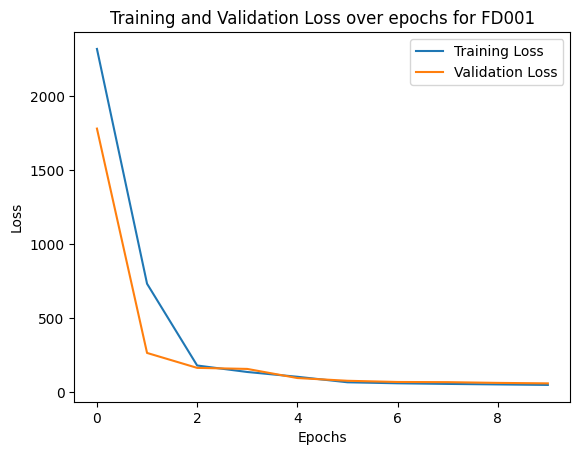

In [33]:
plt.plot(history.history['loss'],label ='Training Loss')
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.title('Training and Validation Loss over epochs for FD001')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()